In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

Fontconfig warning: ignoring UTF-8: not a valid region tag
2023-11-27 10:31:28.339056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_info = pd.read_csv("DATA/lending_club_info.csv", index_col='LoanStatNew')
data_info.head()

,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade


In [3]:
data = pd.read_csv("DATA/lending_club_loan_two.csv")
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [5]:
feat_info("term")

The number of payments on the loan. Values are in months and can be either 36 or 60.


# Exploratory Data Analysis, and Visualization

**OVERALL GOAL: Get an understanding for which variables are important, view summary statistics, and visualize the data.**

By taking a quick look in our data set we immediately see that there are some missing values in particular columns.

If we decide to keep these columns as features for our model, we'll need to handle these NA values.

We also notice that the values of some columns (e.g. term, emp_length etc) are in a string format. We'll need to parce the string and keep only the numeric values as the necessary information.

Finally, we might want to convert other categorical variables into continuous feature variables using one hot encoding.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [7]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

Since we are trying to predict a loan status, before we move on to feature engineering, it is useful to make a countplot to check how many people have succesfully paid back their loan vs how many failed to do so.

We see that the two classes are not well-balanced in the data set, with ~80% of the people having fully paid back their loan and ~20% of people that they charged off.

This means, our model might achieve high accuracy by simply predicting the majority class, but it may perform poorly on the minority class, which is the class of interest.

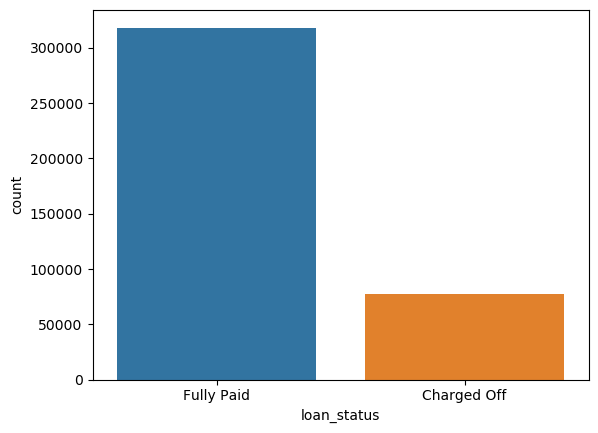

In [8]:
_ = sns.countplot(x=data["loan_status"])

In [9]:
data["loan_status"].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

In [10]:
# People that have fully paid back their loan represent ~80% of the data
318357/len(data["loan_status"])

0.8038709188697826

In [11]:
# People that failed to pay back their loan represent ~20% of the data
77673/len(data["loan_status"])

0.1961290811302174

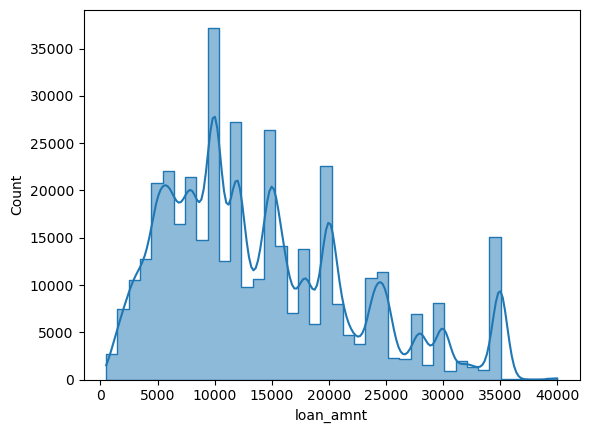

In [12]:
_ = sns.histplot(data["loan_amnt"], kde=True, element="step", bins=40)

Let's calculate the correlation between all continuous numeric variables and visuzalize it using a heatmap.

In [13]:
data.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


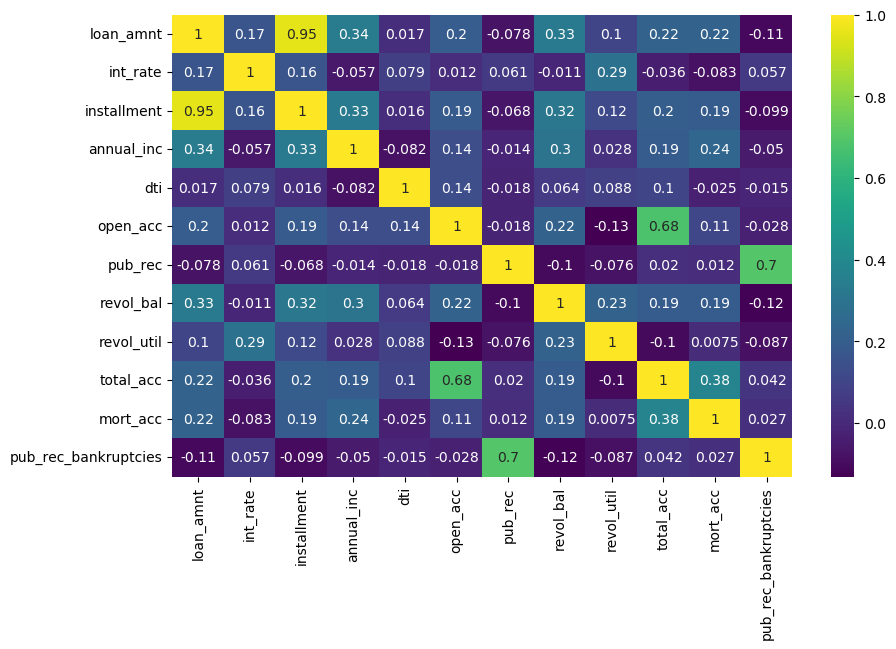

In [14]:
plt.figure(figsize=(10,6))
_ = sns.heatmap(data.corr(), cmap="viridis", annot=True)

We notice that there is almost perfect correlation with the "installment" feature. Let's explore this feature further.

In [15]:
feat_info("installment")

The monthly payment owed by the borrower if the loan originates.


In [16]:
data["installment"].describe()

count    396030.000000
mean        431.849698
std         250.727790
min          16.080000
25%         250.330000
50%         375.430000
75%         567.300000
max        1533.810000
Name: installment, dtype: float64

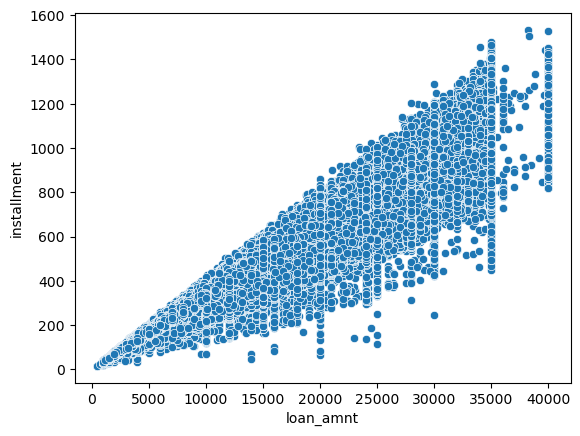

In [17]:
_ = sns.scatterplot(x="loan_amnt", y="installment", data=data)

In [18]:
feat_info("loan_amnt")

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


Given the provided descriptions of the two variables, "installment" and "loan_amnt," and their very high correlation of 0.95, it suggests that these variables contain highly similar information. In many cases, such a high correlation could indicate that the two variables convey essentially the same information, at least in a linear sense.

The high correlation suggests redundancy in the information captured by these two variables. If one variable can be accurately predicted from the other (or vice versa), including both in a predictive model may not provide much additional information.

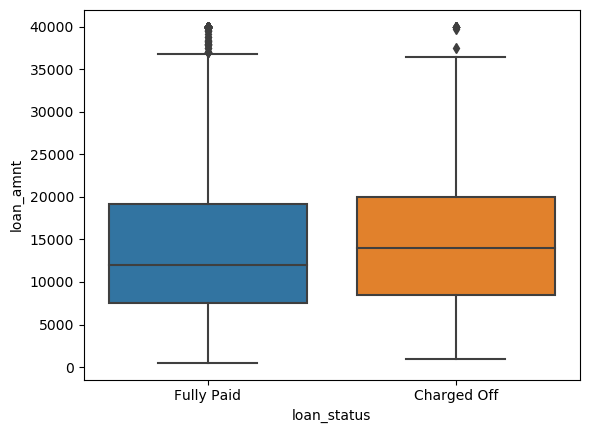

In [19]:
_ = sns.boxplot(x="loan_status", y='loan_amnt', data=data)

In [20]:
data.groupby("loan_status")["loan_amnt"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


Let's explore the Grade and SubGrade columns that LendingClub attributes to the loans. What are the unique possible grades and subgrades?

In [21]:
print(data["grade"].sort_values().unique())

['A' 'B' 'C' 'D' 'E' 'F' 'G']


In [22]:
print(data["sub_grade"].sort_values().unique())

['A1' 'A2' 'A3' 'A4' 'A5' 'B1' 'B2' 'B3' 'B4' 'B5' 'C1' 'C2' 'C3' 'C4'
 'C5' 'D1' 'D2' 'D3' 'D4' 'D5' 'E1' 'E2' 'E3' 'E4' 'E5' 'F1' 'F2' 'F3'
 'F4' 'F5' 'G1' 'G2' 'G3' 'G4' 'G5']


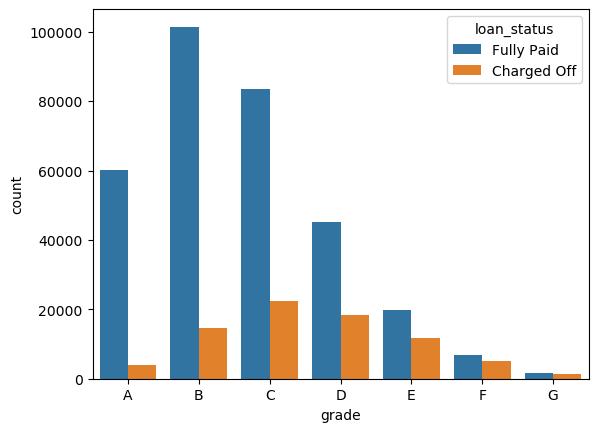

In [23]:
_ = sns.countplot(x="grade", 
                  hue="loan_status", 
                  data=data, 
                  order=data["grade"].sort_values().unique()
                 )

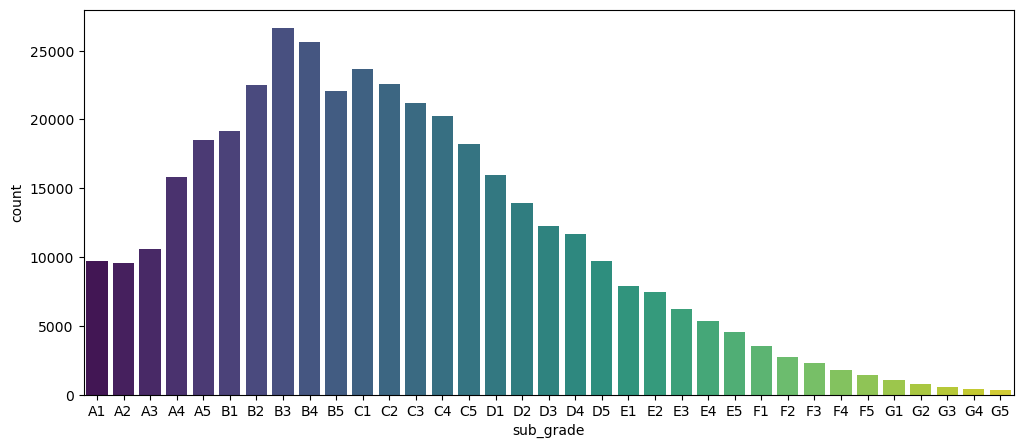

In [24]:
plt.figure(figsize=(12,5))

_ = sns.countplot(x="sub_grade", 
                  data=data, 
                  order=data["sub_grade"].sort_values().unique(), 
                  palette="viridis"
                 )

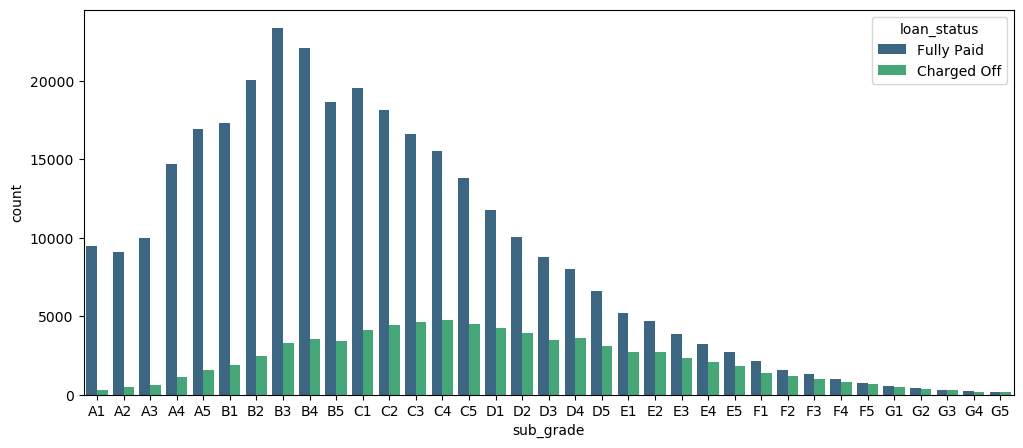

In [25]:
plt.figure(figsize=(12,5))
_ = sns.countplot(x="sub_grade", 
                  hue="loan_status",
                  data=data, 
                  order=data["sub_grade"].sort_values().unique(), 
                  palette="viridis"
                 )

It looks like F and G subgrades don't get paid back that often. Let's isolate those and recreate the countplot just for those subgrades.

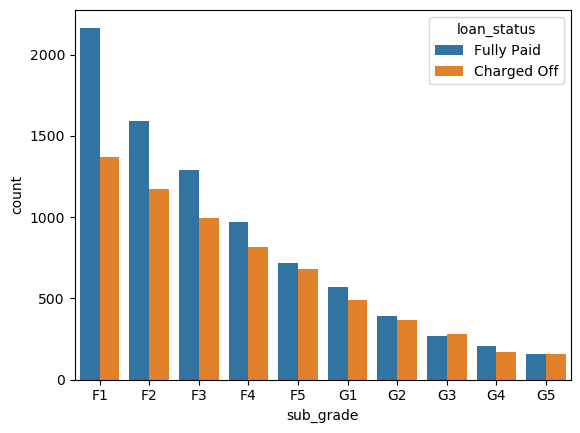

In [26]:
subgrade_mask = data["sub_grade"] > "E5"

_ = sns.countplot(x=data["sub_grade"][subgrade_mask], 
                  hue="loan_status", 
                  data=data,
                  order=data["sub_grade"][subgrade_mask].sort_values().unique()
                 )

Let's now create a new column called 'loan_repaid' which will contain a 1 if the loan status was "Fully Paid" and a 0 if it was "Charged Off".

In [27]:
data["loan_repaid"] = data["loan_status"].apply(lambda s: 0 if s == "Charged Off" else 1)
data[["loan_status", "loan_repaid"]]

,loan_status,loan_repaid
0,Fully Paid,1
1,Fully Paid,1
2,Fully Paid,1
3,Fully Paid,1
4,Charged Off,0
...,...,...
396025,Fully Paid,1
396026,Fully Paid,1
396027,Fully Paid,1
396028,Fully Paid,1


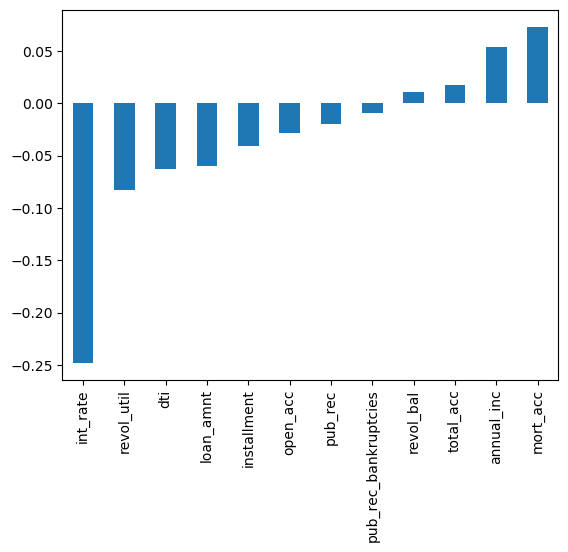

In [28]:
data.corr()["loan_repaid"].sort_values(ascending=True).drop("loan_repaid").plot(kind="bar")

---

# Data PreProcessing and Feature Engineering

**Section Goals: Remove or fill any missing data. Remove unnecessary or repetitive features. Convert categorical string features to dummy variables.**

## Missing values
We use a variety of factors to decide whether or not they would be useful, to see if we should keep, discard, or fill in the missing data.

For starters, let's display the total count of missing values per column. It would be also usefull to convert this Series to be in term of percentage of the total DataFrame.

In [29]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [30]:
data.isnull().sum() * (100/len(data))

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

We immediately notice that "revol_util" and the "pub_rec_bankruptcies" have missing data points, but they account for less than 0.5% of the total data. We will go ahead and remove the rows that are missing those values in those columns.

In [31]:
data = data.dropna(subset=["revol_util", "pub_rec_bankruptcies"], axis=0)

We will continue with the "emp_title" and "emp_length" features to see whether it will be okay to drop them. 

In [32]:
feat_info("emp_title")

The job title supplied by the Borrower when applying for the loan.*


In [33]:
data["emp_title"].nunique()

172650

We see that there are too many unique job titles to reallistically try to convert this to a dummy variable feature. Let's remove that emp_title column.

In [34]:
data = data.drop("emp_title", axis=1)

Let us no parse the "emp_length" feature and extract the information we want.

In [35]:
feat_info("emp_length")

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [36]:
data["emp_length"].nunique()

11

In [37]:
data["emp_length"].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [38]:
def parse_emp_length(s:str) -> float:
    # Keep nan values as it is
    if pd.isna(s): return np.nan
    
    # Parse string and extract the years
    try:
        str_contents = s.split(" ")
        years = float(str_contents[0])
        return years
    
    except ValueError:
        if str_contents[0].startswith("<") : return 0.0  # based on the description
        if str_contents[0].endswith("+") : return 10.0   # based on the description

In [39]:
data["emp_length"] = data["emp_length"].apply(parse_emp_length)

We will now create a count plot of the "emp_length" feature column.

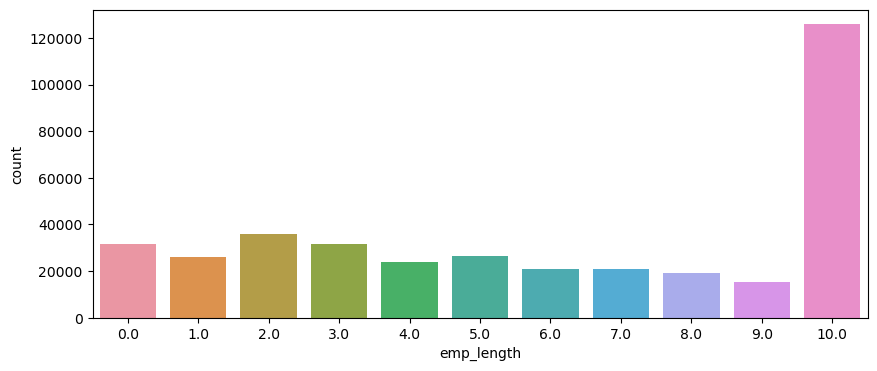

In [40]:
plt.figure(figsize=(10,4))

_ = sns.countplot(x='emp_length', data=data)

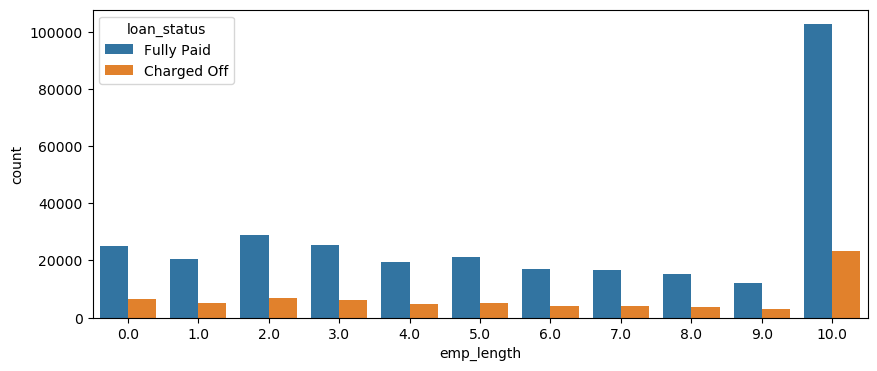

In [41]:
plt.figure(figsize=(10,4))

_ = sns.countplot(x='emp_length', data=data, hue='loan_status')

This still doesn't really inform us if there is a strong relationship between employment length and being charged off, what we want is the percentage of charge offs per category. Essentially informing us what percent of people per employment category didn't pay back their loan.

However, since we converted the categorical data of the "emp_length" feature columns and the "loan_status" label, we can now use the correlation method provided by Pandas to check out the correlation between those two variables.
We see that there is no strong correlation.

In [42]:
data.corr()["loan_repaid"]["emp_length"]

0.013805281879075476

In [43]:
charged_off_per_emp_length = data[data["loan_repaid"] == 0].groupby("emp_length").count()["loan_repaid"]
charged_off_per_emp_length

emp_length
0.0      6532
1.0      5135
2.0      6910
3.0      6176
4.0      4593
5.0      5086
6.0      3939
7.0      4049
8.0      3820
9.0      3066
10.0    23183
Name: loan_repaid, dtype: int64

In [44]:
total_count_per_emp_length = data.groupby("emp_length").count()["loan_repaid"]
total_count_per_emp_length

emp_length
0.0      31564
1.0      25785
2.0      35741
3.0      31598
4.0      23903
5.0      26455
6.0      20803
7.0      20783
8.0      19131
9.0      15290
10.0    125876
Name: loan_repaid, dtype: int64

In [45]:
charged_off_per_emp_length_perc = charged_off_per_emp_length * (100/total_count_per_emp_length)
charged_off_per_emp_length_perc

emp_length
0.0     20.694462
1.0     19.914679
2.0     19.333539
3.0     19.545541
4.0     19.215161
5.0     19.225099
6.0     18.934769
7.0     19.482269
8.0     19.967592
9.0     20.052322
10.0    18.417331
Name: loan_repaid, dtype: float64

Now that we have the percentages of charge offs per category of employmenth length, let's visualize it using a bar plot.

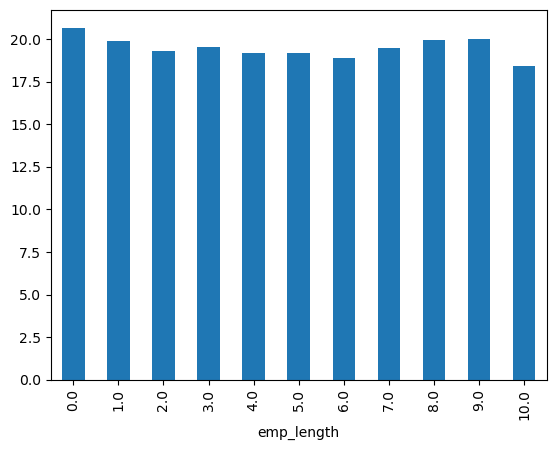

In [46]:
charged_off_per_emp_length_perc.plot(kind='bar')

We see that charge off rates are extremely similar across all employment lengths. We'll go ahead and drop the "emp_length" column.

In [47]:
data = data.drop("emp_length", axis=1)

Let's see what have we accomplished so far.

In [48]:
data.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1754
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                  0
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37205
pub_rec_bankruptcies        0
address                     0
loan_repaid                 0
dtype: int64

Let's review the title column vs the purpose column.

In [49]:
feat_info("purpose")
print()
feat_info("title")

A category provided by the borrower for the loan request. 

The loan title provided by the borrower


In [50]:
data["purpose"].head(10)

0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object

In [51]:
data["title"].head(10)

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object

The "title" column is simply a string subcategory/description of the "purpose" column. Let's drop the "title" column.

In [52]:
data = data.drop("title", axis=1)

Now we will move to the last column with missing values.

Let's find out what the "mort_acc" feature represents.

In [53]:
feat_info("mort_acc")

Number of mortgage accounts.


In [54]:
data["mort_acc"]

0         0.0
1         3.0
2         0.0
3         0.0
4         1.0
         ... 
396025    0.0
396026    1.0
396027    0.0
396028    5.0
396029    NaN
Name: mort_acc, Length: 395219, dtype: float64

In [55]:
data["mort_acc"].value_counts()

0.0     139708
1.0      60384
2.0      49907
3.0      38022
4.0      27865
5.0      18182
6.0      11059
7.0       6050
8.0       3120
9.0       1653
10.0       863
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
26.0         2
32.0         2
31.0         2
23.0         2
34.0         1
28.0         1
30.0         1
Name: mort_acc, dtype: int64

There are many ways we could deal with this missing data. We could attempt to build a simple model to fill it in, such as a linear model, we could just fill it in based on the mean of the other columns, or we could even bin the columns into categories and then set NaN as its own category. 

There is no 100% correct approach! Let's review the other columsn to see which most highly correlates to "mort_acc"

In [56]:
data.corr()["mort_acc"].drop("mort_acc").sort_values(ascending=False)

total_acc               0.381205
annual_inc              0.236277
loan_amnt               0.222381
revol_bal               0.195063
installment             0.193752
open_acc                0.109440
loan_repaid             0.073048
pub_rec_bankruptcies    0.027273
pub_rec                 0.011576
revol_util              0.007514
dti                    -0.025401
int_rate               -0.082656
Name: mort_acc, dtype: float64

In [57]:
feat_info("total_acc")

The total number of credit lines currently in the borrower's credit file


Looks like the "total_acc" feature correlates with the "mort_acc" , this makes sense! We will group the dataframe by the "total_acc" and calculate the mean value for the "mort_acc" per "total_acc" entry. Then we will fill the missing values using this value.

In [58]:
print("Mean of mort_acc column per total_acc")
data.groupby("total_acc")["mort_acc"].mean()

Mean of mort_acc column per total_acc


total_acc
2.0      0.000000
3.0      0.052326
4.0      0.066743
5.0      0.102108
6.0      0.151123
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64

Let's fill in the missing "mort_acc" values based on their "total_acc" value. If the "mort_acc" is missing, then we will fill in that missing value with the mean value corresponding to its "total_acc" value from the Series we created above.

In [59]:
def fill_mort_acc(total_acc: float, mort_acc: float) -> float:
    if np.isnan(mort_acc):
        return data.groupby("total_acc")["mort_acc"].mean()[total_acc]
    else:
        return mort_acc

In [60]:
data["mort_acc"] = data.apply(lambda row: fill_mort_acc(row["total_acc"], row["mort_acc"]), axis=1)

In [61]:
data.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

## Categorical Variables and Dummy Variables
We're done working with the missing data! Now we just need to deal with the string values due to the categorical columns.

Let's list all the columns that are currently non-numeric.

In [62]:
data.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

Let's now go through all the string features to see what we should do with them.

### term feature
Convert the term feature into either a 36 or 60 integer numeric data type using .apply() or .map().

In [63]:
feat_info("term")

The number of payments on the loan. Values are in months and can be either 36 or 60.


In [64]:
data["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [65]:
data["term"] = data["term"].apply(lambda x: int(x.split(" ")[1]))

### grade feature
We already know grade is part of sub_grade, so just drop the grade feature.

In [66]:
data = data.drop("grade", axis=1)

Convert the "subgrade" into dummy variables. Then concatenate these new columns to the original dataframe. Remember to drop the original "subgrade" column and to add ``drop_first=True`` to your ``get_dummies`` call.

In [67]:
subgrade_dummies = pd.get_dummies(data["sub_grade"], drop_first=True)
subgrade_dummies

,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
396026,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
396027,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
data = pd.concat([data.drop("sub_grade", axis=1), subgrade_dummies], axis=1)
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address',
       'loan_repaid', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4',
       'G5'],
      dtype='object')

In [69]:
data.select_dtypes("object").columns

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

### verification_status, application_type,initial_list_status,purpose
Convert these columns: ['verification_status', 'application_type','initial_list_status','purpose'] into dummy variables and concatenate them with the original dataframe. Remember to set drop_first=True and to drop the original columns.

In [70]:
feat_info("verification_status")
feat_info("application_type")
feat_info("initial_list_status")
feat_info("purpose")

Indicates if income was verified by LC, not verified, or if the income source was verified
Indicates whether the loan is an individual application or a joint application with two co-borrowers
The initial listing status of the loan. Possible values are – W, F
A category provided by the borrower for the loan request. 


In [71]:
data["verification_status"].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

In [72]:
data["verification_status"].value_counts()

Verified           139451
Source Verified    131301
Not Verified       124467
Name: verification_status, dtype: int64

In [73]:
data["application_type"].unique()

array(['INDIVIDUAL', 'JOINT', 'DIRECT_PAY'], dtype=object)

In [74]:
data["application_type"].value_counts()

INDIVIDUAL    394508
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [75]:
data["initial_list_status"].unique()

array(['w', 'f'], dtype=object)

In [76]:
data["initial_list_status"].value_counts()

f    237346
w    157873
Name: initial_list_status, dtype: int64

In [77]:
data["purpose"].unique()

array(['vacation', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'major_purchase', 'other',
       'medical', 'wedding', 'car', 'moving', 'house', 'educational',
       'renewable_energy'], dtype=object)

In [78]:
data["purpose"].value_counts()

debt_consolidation    234169
credit_card            82923
home_improvement       23961
other                  21059
major_purchase          8756
small_business          5656
car                     4670
medical                 4175
moving                  2842
vacation                2442
house                   2197
wedding                 1794
renewable_energy         329
educational              246
Name: purpose, dtype: int64

In [79]:
# Get dummies for each of the categorical features

dummies = pd.get_dummies(data[['verification_status', 'application_type','initial_list_status','purpose' ]],
                         drop_first=True)
data = data.drop(['verification_status', 'application_type','initial_list_status','purpose'],axis=1)

In [80]:
# concatenate to original dataframe
data = pd.concat([data,dummies],axis=1)

### home_ownership
Review the value_counts for the home_ownership column.

In [81]:
data["home_ownership"].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

Convert these to dummy variables, but replace NONE and ANY with OTHER, so that we end up with just 4 categories, MORTGAGE, RENT, OWN, OTHER. Then concatenate them with the original dataframe. 

In [82]:
data["home_ownership"] = data["home_ownership"].replace(["NONE", "ANY"], "OTHER")

In [83]:
home_ownership_dummies = pd.get_dummies(data["home_ownership"], drop_first=True)

In [84]:
data = pd.concat([data.drop("home_ownership", axis=1), home_ownership_dummies], axis=1)

### address
Let's feature engineer a zip code column from the "address" in the data set. Create a column called 'zip_code' that extracts the zip code from the "address" column.

In [85]:
data["address"].head(5)

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [86]:
data["zip_code"] = data["address"].apply(lambda x: x.split(" ")[-1])

In [87]:
data["zip_code"]

0         22690
1         05113
2         05113
3         00813
4         11650
          ...  
396025    30723
396026    05113
396027    70466
396028    29597
396029    48052
Name: zip_code, Length: 395219, dtype: object

Now make this zip_code column into dummy variables.

In [88]:
zip_code_dummies = pd.get_dummies(data["zip_code"], drop_first=True)
data = pd.concat([data.drop(["zip_code", "address"], axis=1), zip_code_dummies], axis=1)

### issue_d
**This would be data leakage**, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [89]:
feat_info("issue_d")

The month which the loan was funded


In [90]:
data = data.drop("issue_d", axis=1)

### earliest_cr_line
This appears to be a historical time stamp feature. Extract the year from this feature, then convert it to a numeric feature. Set this new data to a feature column called 'earliest_cr_year'. Then drop the "earliest_cr_line" feature.

In [91]:
feat_info("earliest_cr_line")

The month the borrower's earliest reported credit line was opened


In [92]:
data["earliest_cr_line"]

0         Jun-1990
1         Jul-2004
2         Aug-2007
3         Sep-2006
4         Mar-1999
            ...   
396025    Nov-2004
396026    Feb-2006
396027    Mar-1997
396028    Nov-1990
396029    Sep-1998
Name: earliest_cr_line, Length: 395219, dtype: object

In [93]:
# Create the new column that contains the numeric representation of the year.
data["earliest_cr_year"] = data["earliest_cr_line"].apply(lambda x: int(x.split("-")[-1]))

# Drop the earliest_cr_line column
data = data.drop("earliest_cr_line", axis=1)

Finally, drop the "load_status" column, since its a duplicate of the "loan_repaid" column we created earlier. We'll use the "loan_repaid" column since its already in 0s and 1s.

In [94]:
data = data.drop("loan_status", axis=1)

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 79 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   annual_inc                           395219 non-null  float64
 5   dti                                  395219 non-null  float64
 6   open_acc                             395219 non-null  float64
 7   pub_rec                              395219 non-null  float64
 8   revol_bal                            395219 non-null  float64
 9   revol_util                           395219 non-null  float64
 10  total_acc                            395219 non-null  float64
 11  mort_acc     

# Split and normalize data

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [97]:
# The features
X = data.drop("loan_repaid", axis=1).values

# The target
y = data["loan_repaid"].values

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [98]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(296414, 78) (296414,)
(98805, 78) (98805,)


In [99]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

1    238198
0     58216
dtype: int64

Because our data set is imbalanced we will try to remedy this by assignining different weights to each class.

In [101]:
total_samples = len(y_train)
num_classes = 2

num_samples_class_0 = y_train_series.value_counts()[0] # not fully paid back
num_samples_class_1 = y_train_series.value_counts()[1] # fully paid back 

weight_for_class_0 = total_samples / (num_classes * num_samples_class_0)
weight_for_class_1 = total_samples / (num_classes * num_samples_class_1)

class_weights = {0: weight_for_class_0, 1: weight_for_class_1}

print("Class Weights:", class_weights)

Class Weights: {0: 2.5458121478631304, 1: 0.6222008581096399}


# Create a Neural Network

In [102]:
model = Sequential()

model.add(Dense(X_train.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1]*2, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1]//2, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1]//4, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [103]:
early_stop = EarlyStopping(patience=20)

In [104]:
model.fit(X_train,
          y_train, 
          validation_data=(X_test, y_test), 
          batch_size=256,
          epochs=100, 
          callbacks=[early_stop],
          #class_weight=class_weights
         )

Epoch 1/100
1158/1158 [==============================] - 5s 4ms/step - loss: 0.2929 - accuracy: 0.8785 - val_loss: 0.2613 - val_accuracy: 0.8888
Epoch 2/100
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2635 - accuracy: 0.8877 - val_loss: 0.2602 - val_accuracy: 0.8890
Epoch 3/100
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2622 - accuracy: 0.8878 - val_loss: 0.2601 - val_accuracy: 0.8889
Epoch 4/100
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2612 - accuracy: 0.8878 - val_loss: 0.2607 - val_accuracy: 0.8888
Epoch 5/100
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2608 - accuracy: 0.8879 - val_loss: 0.2613 - val_accuracy: 0.8888
Epoch 6/100
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2604 - accuracy: 0.8880 - val_loss: 0.2614 - val_accuracy: 0.8889
Epoch 7/100
1158/1158 [==============================] - 4s 3ms/step - loss: 0.2600 - accuracy: 0.8881 - val_loss: 0.2599 - val_ac

# Evaluate Model Performance

In [105]:
from sklearn.metrics import classification_report,confusion_matrix

In [106]:
df_losses = pd.DataFrame(model.history.history)
df_losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.292906,0.878521,0.261326,0.888842
1,0.263541,0.887674,0.260249,0.888983
2,0.262231,0.887762,0.260099,0.888852
3,0.261192,0.887755,0.260700,0.888842
4,0.260764,0.887910,0.261343,0.888842


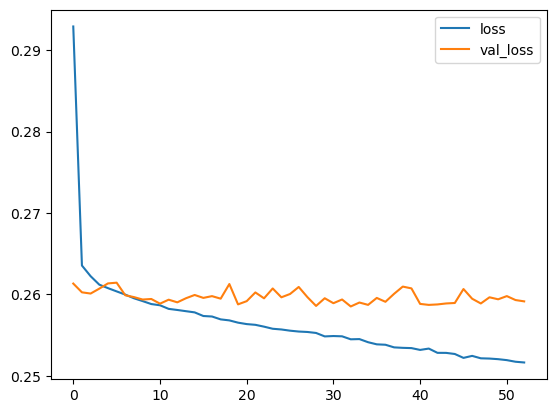

In [107]:
df_losses[["loss", "val_loss"]].plot()

In [108]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")

3088/3088 [==============================] - 3s 1ms/step


In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.47      0.62     19307
           1       0.88      0.99      0.93     79498

    accuracy                           0.89     98805
   macro avg       0.91      0.73      0.78     98805
weighted avg       0.89      0.89      0.87     98805



In [110]:
print(confusion_matrix(y_test, y_pred))

[[ 8984 10323]
 [  671 78827]]


### Class 0:

- **Precision (Positive Predictive Value):** 0.93
  - The high precision for class 0 (93%) indicates that when the model predicts class 0, it is quite accurate. This is especially notable considering the imbalanced nature of the dataset.

- **Recall (Sensitivity or True Positive Rate):** 0.47
  - The lower recall for class 0 (47%) suggests that the model is less successful in capturing all instances of class 0. This may be due to the imbalanced class distribution, where the model is biased towards predicting the majority class (class 1).

- **F1-Score:** 0.62
  - The F1 score for class 0 is a balance between precision and recall. In this case, it reflects the challenge of achieving both high precision and recall simultaneously in an imbalanced dataset.

### Class 1:

- **Precision (Positive Predictive Value):** 0.88
  - The precision for class 1 (88%) is high, indicating that when the model predicts class 1, it is accurate. This is crucial given the larger representation of class 1 in the dataset.

- **Recall (Sensitivity or True Positive Rate):** 0.99
  - The almost perfect recall for class 1 (99%) suggests that the model effectively captures all instances of class 1. This might be expected, considering the larger number of instances of class 1 in the dataset.

- **F1-Score:** 0.93
  - The high F1 score for class 1 reflects the good balance between precision and recall. The model is effective in predicting class 1 instances.

### Overall Considerations:

- **Accuracy:** 0.89
  - While accuracy is high, it may not be the most informative metric in imbalanced datasets. In this case, the model may be biased towards the majority class (class 1), and accuracy can be influenced by this class imbalance.

- **Class Imbalance Impact:**
  - The class imbalance in the dataset likely influences the model's behavior. The high precision for class 0 suggests that the model is cautious when predicting this minority class. However, the lower recall for class 0 indicates a challenge in capturing all instances of this class.

- **Consideration for Application:**
  - Depending on the specific requirements of your application, we may need to weigh the importance of precision and recall differently. For example, if the cost of false negatives (missing instances of class 0) is high, we may want to focus on improving recall for class 0.

In summary, while the model performs well overall, it's important to be mindful of the imbalanced nature of the dataset and consider the implications of the model's predictions in the context of the application's goals and requirements.

# Make predictions on new data
Given the customer below, would you offer this person a loan?

In [118]:
import random
random.seed(101)
random_ind = random.randint(0,len(data))

new_customer = data.drop('loan_repaid',axis=1).iloc[random_ind]
new_customer

loan_amnt           25000.00
term                   60.00
int_rate               18.24
installment           638.11
annual_inc          61665.00
                      ...   
48052                   0.00
70466                   0.00
86630                   0.00
93700                   0.00
earliest_cr_year     1996.00
Name: 305323, Length: 78, dtype: float64

In [119]:
new_customer = scaler.transform(new_customer.values.reshape(-1,78))

new_customer_pred = (model.predict(new_customer.reshape(-1,78)) > 0.5).astype("int32")

1/1 [==============================] - 0s 19ms/step


In [120]:
prediction = "gets a loan" if new_customer_pred == 1 else "does not get a loan"

print(f"New customer {prediction}!")

New customer gets a loan!


Now check, did this person actually end up paying back their loan?

In [121]:
data.loc[random_ind, "loan_repaid"]

1